!pip uninstall tensorflow

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pickle
import time
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
import logging
logging.disable(logging.WARNING) # disable WARNING, INFO and DEBUG logging everywhere
data=pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')
data

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43 +0000,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,Oren Empower Extra Large Self Adhesive Sticker...,No rating available,No rating available,Oren Empower,"{""product_specification""=>[{""key""=>""Number of ..."
1046,fd6cbcc22efb6b761bd564c28928483c,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-large-vinyl...,Wallmantra Large Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIEC889ZD5GDCVQ,4930.0,1896.0,fd6cbcc22efb6b761bd564c28928483c.jpg,False,Wallmantra Large Vinyl Sticker Sticker (Pack o...,No rating available,No rating available,Wallmantra,"{""product_specification""=>[{""key""=>""Number of ..."
1047,5912e037d12774bb73a2048f35a00009,2015-12-01 10:15:43 +0000,http://www.flipkart.com/uberlyfe-extra-large-p...,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE5UVGW2JWVWCT,4500.0,1449.0,5912e037d12774bb73a2048f35a00009.jpg,False,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,No rating available,No rating available,Uberlyfe,"{""product_specification""=>[{""key""=>""Number of ..."
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-medium-viny...,Wallmantra Medium Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >.

In [2]:
# Tokenizer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

def tokenizer_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words
from nltk.corpus import stopwords
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@")) 
    #                                   and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw

# Lemmatizer (base d'un mot)
from nltk.stem import WordNetLemmatizer

def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)
def transform_bow_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

data['sentence_bow'] = data['description'].apply(lambda x : transform_bow_fct(x))
data['sentence_bow_lem'] = data['description'].apply(lambda x : transform_bow_lem_fct(x))
data['sentence_dl'] = data['description'].apply(lambda x : transform_dl_fct(x))
data.shape

(1050, 18)

In [3]:
example="These are some examples."
display(transform_bow_fct(example))
display(transform_bow_lem_fct(example))
display(transform_dl_fct(example))

'these examples'

'these example'

'these are some examples .'

In [4]:
data

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,sentence_bow,sentence_bow_lem,sentence_dl
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",key features elegance polyester multicolor abs...,key feature elegance polyester multicolor abst...,key features of elegance polyester multicolor ...
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",specifications sathiyas cotton bath towel bath...,specification sathiyas cotton bath towel bath ...,specifications of sathiyas cotton bath towel (...
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",key features eurospa cotton terry face towel s...,key feature eurospa cotton terry face towel se...,key features of eurospa cotton terry face towe...
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",key features santosh royal fashion cotton prin...,key feature santosh royal fashion cotton print...,key features of santosh royal fashion cotton p...
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",key features jaipur print cotton floral king s...,key feature jaipur print cotton floral king si...,key features of jaipur print cotton floral kin...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43 +0000,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,Oren Empower Extra Large Self Adhesive Sticker...,No rating available,No rating available,Oren Empower,"{""product_specification""=>[{""key""=>""Number of ...",oren empower extra large self adhesive sticker...,oren empower extra large self adhesive sticker...,oren empower extra large self adhesive sticker...
1046,fd6cbcc22efb6b761bd564c28928483c,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-large-vinyl...,Wallmantra Large Vin

In [5]:
data.to_csv("data_tweets2_3000.csv")

In [6]:
data_T =  pd.read_csv("data_tweets2_3000.csv")
print(data_T.shape)

(1050, 19)


In [7]:
data_T['category']=data_T['product_category_tree'].str.split('>').map(lambda x: x[0]).str.split('"').map(lambda x: x[1])
data_T

,Unnamed: 0,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,sentence_bow,sentence_bow_lem,sentence_dl,category
0,0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",key features elegance polyester multicolor abs...,key feature elegance polyester multicolor abst...,key features of elegance polyester multicolor ...,Home Furnishing
1,1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",specifications sathiyas cotton bath towel bath...,specification sathiyas cotton bath towel bath ...,specifications of sathiyas cotton bath towel (...,Baby Care
2,2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",key features eurospa cotton terry face towel s...,key feature eurospa cotton terry face towel se...,key features of eurospa cotton terry face towe...,Baby Care
3,3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",key features santosh royal fashion cotton prin...,key feature santosh royal fashion cotton print...,key features of santosh royal fashion cotton p...,Home Furnishing
4,4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",key features jaipur print cotton floral king s...,key feature jaipur print cotton floral king si...,key features of jaipur print cotton floral kin...,Home Furnishing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43 +0000,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,Oren Empower Extra Large Self Adhesive Sticker...,No rating available,No rating available,Oren Empower,"{""product_specification""=>[{""key""=>""Number of ...",oren empower extra large self adhesive sticker...,oren empower extra large self adhesive sticker...,oren empower extra large self adhesive sticker...,Baby Care
1046,1046,fd6

In [8]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
data_T['cat_number'] = le.fit_transform(data_T['category'])
data_T

,Unnamed: 0,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,...,description,product_rating,overall_rating,brand,product_specifications,sentence_bow,sentence_bow_lem,sentence_dl,category,cat_number
0,0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,...,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",key features elegance polyester multicolor abs...,key feature elegance polyester multicolor abst...,key features of elegance polyester multicolor ...,Home Furnishing,4
1,1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,...,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",specifications sathiyas cotton bath towel bath...,specification sathiyas cotton bath towel bath ...,specifications of sathiyas cotton bath towel (...,Baby Care,0
2,2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,...,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",key features eurospa cotton terry face towel s...,key feature eurospa cotton terry face towel se...,key features of eurospa cotton terry face towe...,Baby Care,0
3,3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,...,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",key features santosh royal fashion cotton prin...,key feature santosh royal fashion cotton print...,key features of santosh royal fashion cotton p...,Home Furnishing,4
4,4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,...,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",key features jaipur print cotton floral king s...,key feature jaipur print cotton floral king si...,key features of jaipur print cotton floral kin...,Home Furnishing,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43 +0000,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,...,Oren Empower Extra Large Self Adhesive Sticker...,No rating available,No rating available,Oren Empower,"{""product_specification""=>[{""key""=>""Number of ...",oren empower extra large self adhesive sticker...,oren empower extra large self adhesive sticker...,oren empower extra large self adhesive sticker...,Baby Care,0
1046,1046,fd6cbcc2

In [9]:
l_cat = list(set(data_T['category']))
print("catégories : ", l_cat)
y_cat_num = [(1-l_cat.index(data_T.iloc[i]['category'])) for i in range(len(data_T))]

catégories :  ['Kitchen & Dining ', 'Home Decor & Festive Needs ', 'Watches ', 'Baby Care ', 'Home Furnishing ', 'Beauty and Personal Care ', 'Computers ']


In [10]:
from nltk.tokenize import sent_tokenize, word_tokenize

data_T['length_bow'] = data_T['sentence_bow'].apply(lambda x : len(word_tokenize(x)))
print("max length bow : ", data_T['length_bow'].max())
data_T['length_dl'] = data_T['sentence_dl'].apply(lambda x : len(word_tokenize(x)))
print("max length dl : ", data_T['length_dl'].max())


max length bow :  379
max length dl :  632


In [11]:
import time

# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des articles par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des articles par clusters')
    
    plt.show()
    print("ARI : ", ARI)

In [12]:
# création du bag of words (CountVectorizer et Tf-idf)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

feat = 'sentence_bow_lem'
cv_fit = cvect.fit(data_T[feat])
ctf_fit = ctf.fit(data_T[feat])

cv_transform = cvect.transform(data_T[feat])  
ctf_transform = ctf.transform(data_T[feat])  

In [13]:
print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct(cv_transform)
print()
print("Tf-idf : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(ctf_transform)


CountVectorizer : 
-----------------
ARI :  0.3678 time :  5.0

Tf-idf : 
--------
ARI :  0.5154 time :  4.0


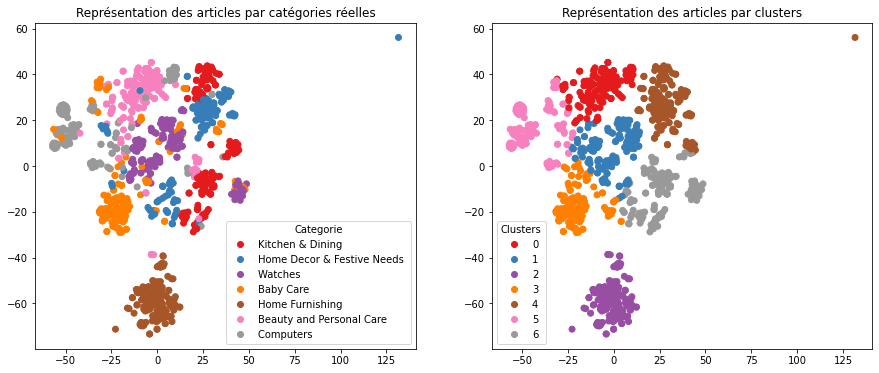

ARI :  0.5154


In [14]:
 TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

In [15]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

In [16]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 24 # adapt to length of sentences
sentences = data_T['sentence_bow_lem'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [17]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 4712
Word2Vec trained


In [18]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 4713


In [19]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (4713, 300)


In [20]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24)]              0         
                                                                 
 embedding (Embedding)       (None, 24, 300)           1413900   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 1,413,900
Trainable params: 1,413,900
Non-trainable params: 0
_________________________________________________________________


In [21]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 0s 469us/step


(1050, 300)

In [22]:
ARI, X_tsne, labels = ARI_fct(embeddings)

ARI :  0.2885 time :  3.0


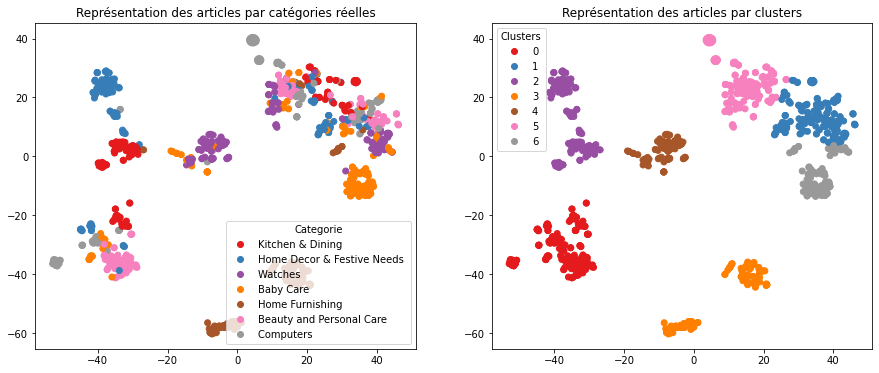

ARI :  0.2885


In [23]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

pip install transformers

In [24]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

In [25]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.9.1
2.9.1
Num GPUs Available:  0
True


In [26]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

In [27]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = data_T['sentence_dl'].to_list()

In [28]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

1/1 [==============================] - 0s 353ms/step
temps traitement :  47.0


In [29]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.3261 time :  4.0


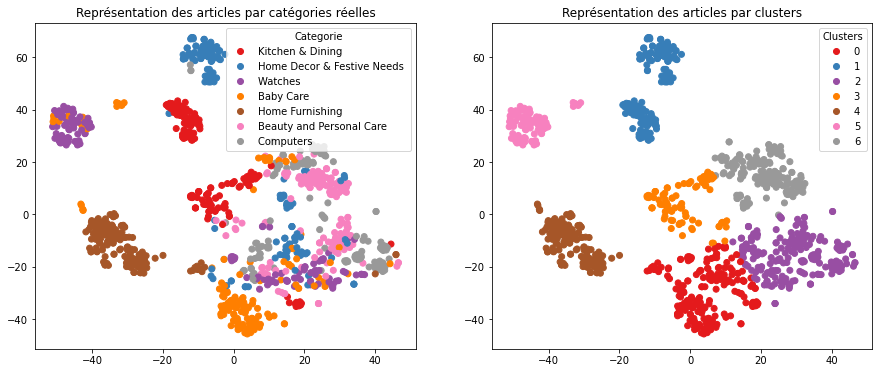

ARI :  0.3261


In [30]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

In [31]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

In [32]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.9.1
2.9.1
Num GPUs Available:  0
True


!pip install "tensorflow>=2.0.0"
!pip install --upgrade tensorflow-hub

!pip uninstall "tensorflow>=2.0.0"

In [33]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [34]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [35]:
batch_size = 10
sentences = data_T['sentence_dl'].to_list()

In [36]:
features_USE = feature_USE_fct(sentences, batch_size)

In [37]:
ARI, X_tsne, labels = ARI_fct(features_USE)

ARI :  0.4354 time :  4.0


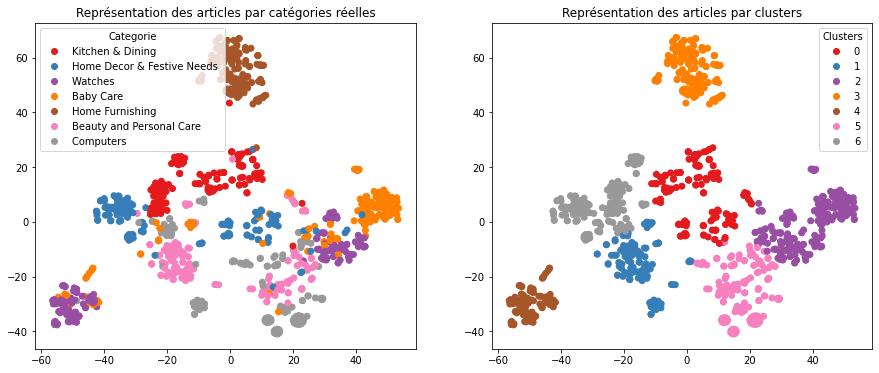

ARI :  0.4354


In [38]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# Reconnaissance d'images

Kitchen & Dining 


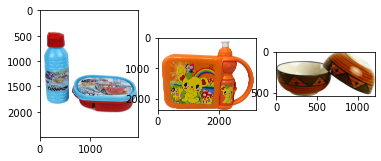

Home Decor & Festive Needs 


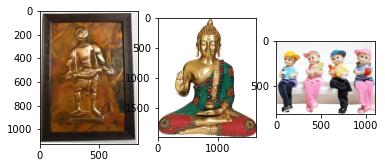

Watches 


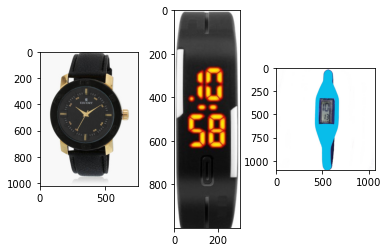

Baby Care 


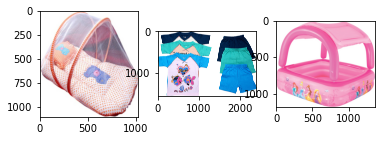

Home Furnishing 


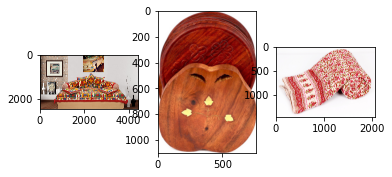

Beauty and Personal Care 


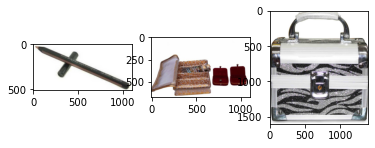

Computers 


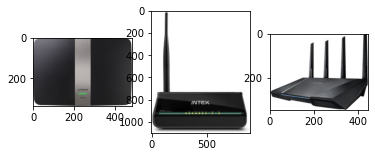

In [39]:
from matplotlib.image import imread
from os import listdir
path = "Images/"

data=data_T

def list_fct(name) :
    list_image_name = [list_photos[i] for i in range(len(data)) if data["category"][i]==name]
    return list_image_name
list_photos = data["image"]

list_beauty=[list_photos[i] for i in range(len(data)) if data["category"][i]=="Beauty and Personal Care "]
list_home=[list_photos[i] for i in range(len(data)) if data["category"][i]=="Home Decor & Festive Needs "]
list_kitchen=[list_photos[i] for i in range(len(data)) if data["category"][i]=="Kitchen & Dining "]
list_watches=[list_photos[i] for i in range(len(data)) if data["category"][i]=="Watches "]
list_comp=[list_photos[i] for i in range(len(data)) if data["category"][i]=="Computers "]
list_baby=[list_photos[i] for i in range(len(data)) if data["category"][i]=="Baby Care "]
list_furn=[list_photos[i] for i in range(len(data)) if data["category"][i]=="Home Furnishing "]

for name in l_cat :
    print(name)
    # print("-------")
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = path + list_fct(name)[i+10]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

pip install opencv-contrib-python --user

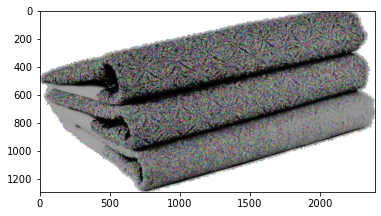

Descripteurs :  (47651, 128)

[[ 85. 113.  31. ...   0.   0.   0.]
 [ 29.  80.  73. ...   0.   0.   0.]
 [ 10.  67. 115. ...   0.   0.  22.]
 ...
 [  0.   0.   0. ...   0.   0.  13.]
 [ 40.   0.   0. ...   0.   0.  51.]
 [ 37.   1.   0. ...   0.   0.   0.]]


In [40]:
import cv2

sift = cv2.xfeatures2d.SIFT_create()
image = cv2.imread(path+list_photos[1],0) # convert in gray
image = cv2.equalizeHist(image)   # equalize image histogram
kp, des = sift.detectAndCompute(image, None)
img=cv2.drawKeypoints(image,kp,image)
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)

In [41]:
# identification of key points and associated descriptors
import time, cv2
sift_keypoints = []
temps1=time.time()
sift = cv2.xfeatures2d.SIFT_create(500)

for image_num in range(len(list_photos)) :
    if image_num%100 == 0 : print(image_num)
    image = cv2.imread(path+list_photos[image_num],0) # convert in gray
    # image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    res = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = sift.detectAndCompute(res, None)
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000


C:\Users\theop\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)



Nombre de descripteurs :  (517351, 128)
temps de traitement SIFT descriptor :           262.94 secondes


In [42]:
from sklearn import cluster, metrics

# Determination number of clusters
temps1=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  719
Création de 719 clusters de descripteurs ...


C:\Users\theop\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


temps de traitement kmeans :            30.28 secondes


In [43]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :             1.80 secondes


In [44]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 719)
Dimensions dataset après réduction PCA :  (1050, 504)


In [45]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["category"]
print(df_tsne.shape)


(1050, 3)


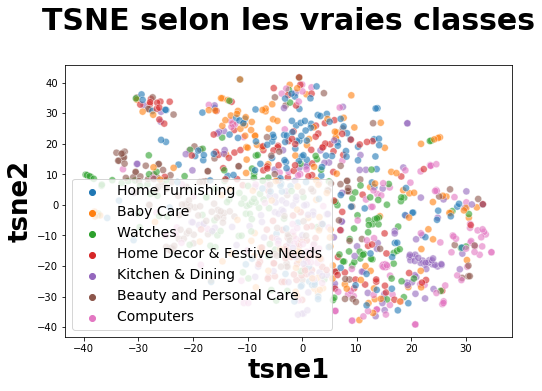

In [46]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()


In [47]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)


(1050, 4)


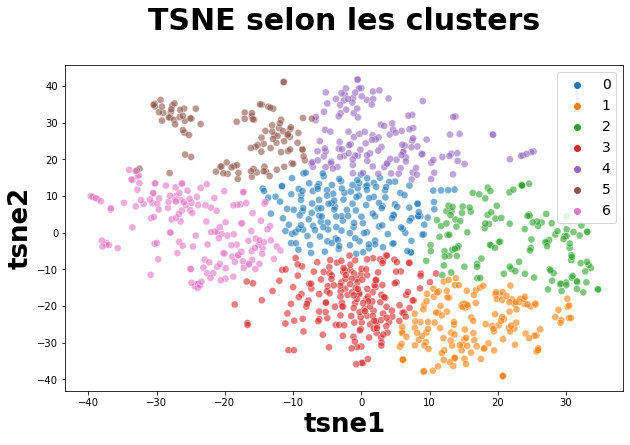

ARI :  0.06628510169273912


In [48]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = data["cat_number"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

In [49]:
df_tsne.groupby("cluster").count()["class"]

cluster
0    171
1    158
2    130
3    189
4    140
5    105
6    157
Name: class, dtype: int64

In [50]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[17 17 20 30 28 28 10]
 [25 10  5 18  7 10 75]
 [10 42 47 25  9  6 11]
 [21 17  6 49 32 22  3]
 [26  9 17 19 49 23  7]
 [35 43 13 27  9 10 13]
 [37 20 22 21  6  6 38]]


In [51]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    # corresp = np.argmax(conf_mat, axis=0)
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [6 5 2 3 4 0 1]
[[28 10 20 30 28 17 17]
 [10 75  5 18  7 10 25]
 [ 6 11 47 25  9 42 10]
 [22  3  6 49 32 17 21]
 [23  7 17 19 49  9 26]
 [10 13 13 27  9 43 35]
 [ 6 38 22 21  6 20 37]]

              precision    recall  f1-score   support

           0       0.27      0.19      0.22       150
           1       0.48      0.50      0.49       150
           2       0.36      0.31      0.34       150
           3       0.26      0.33      0.29       150
           4       0.35      0.33      0.34       150
           5       0.27      0.29      0.28       150
           6       0.22      0.25      0.23       150

    accuracy                           0.31      1050
   macro avg       0.31      0.31      0.31      1050
weighted avg       0.31      0.31      0.31      1050



<AxesSubplot:>

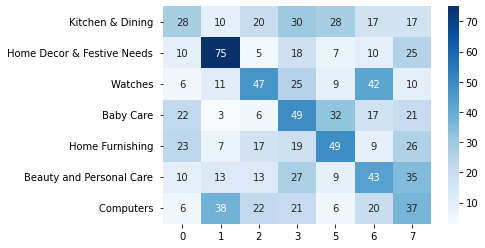

In [52]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in l_cat],
                  columns = [i for i in "0123567"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

In [53]:
# Import TensorFlow
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [54]:
list_photos

0       55b85ea15a1536d46b7190ad6fff8ce7.jpg
1       7b72c92c2f6c40268628ec5f14c6d590.jpg
2       64d5d4a258243731dc7bbb1eef49ad74.jpg
3       d4684dcdc759dd9cdf41504698d737d8.jpg
4       6325b6870c54cd47be6ebfbffa620ec7.jpg
                        ...                 
1045    958f54f4c46b53c8a0a9b8167d9140bc.jpg
1046    fd6cbcc22efb6b761bd564c28928483c.jpg
1047    5912e037d12774bb73a2048f35a00009.jpg
1048    c3edc504d1b4f0ba6224fa53a43a7ad6.jpg
1049    f2f027ad6a6df617c9f125173da71e44.jpg
Name: image, Length: 1050, dtype: object

In [55]:
images=[]
filename = path + list_photos
display(filename)
for i in filename :
    img=cv2.imread(i)
    res = cv2.resize(img, dsize=(400, 400), interpolation=cv2.INTER_CUBIC)
    images.append(res)
display(images[0])

0       Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg
1       Images/7b72c92c2f6c40268628ec5f14c6d590.jpg
2       Images/64d5d4a258243731dc7bbb1eef49ad74.jpg
3       Images/d4684dcdc759dd9cdf41504698d737d8.jpg
4       Images/6325b6870c54cd47be6ebfbffa620ec7.jpg
                           ...                     
1045    Images/958f54f4c46b53c8a0a9b8167d9140bc.jpg
1046    Images/fd6cbcc22efb6b761bd564c28928483c.jpg
1047    Images/5912e037d12774bb73a2048f35a00009.jpg
1048    Images/c3edc504d1b4f0ba6224fa53a43a7ad6.jpg
1049    Images/f2f027ad6a6df617c9f125173da71e44.jpg
Name: image, Length: 1050, dtype: object

array([[[181, 193, 197],
        [180, 192, 196],
        [180, 192, 198],
        ...,
        [157, 166, 175],
        [158, 167, 176],
        [158, 167, 176]],

       [[193, 202, 206],
        [194, 203, 207],
        [195, 204, 208],
        ...,
        [158, 167, 176],
        [159, 168, 177],
        [158, 167, 176]],

       [[203, 208, 207],
        [204, 209, 208],
        [201, 206, 207],
        ...,
        [159, 168, 177],
        [158, 167, 176],
        [158, 167, 176]],

       ...,

       [[136, 163, 197],
        [142, 170, 201],
        [140, 168, 202],
        ...,
        [ 66,  25,  63],
        [113,  74, 112],
        [ 99,  70, 109]],

       [[138, 173, 207],
        [137, 172, 206],
        [141, 173, 208],
        ...,
        [ 49,  10,  48],
        [133,  92, 129],
        [ 86,  58,  94]],

       [[137, 175, 210],
        [138, 176, 211],
        [140, 176, 212],
        ...,
        [ 84,  49,  89],
        [ 70,  39,  76],
        [109,  86, 124]]

In [56]:
from sklearn.model_selection import train_test_split
train_images, test_images, train_labels, test_labels = train_test_split(images, data_T['category'], test_size = 0.2, random_state = 101)

from sklearn.model_selection import train_test_split
train_images, val_images, train_labels, val_labels = train_test_split(images, data_T['category'], train_size=0.9, test_size=0.1, random_state=42)# Create the Test and Final Training Datasets
train_images, test_images, train_labels, test_labels = train_test_split(train_images, train_labels, train_size=0.78, random_state=42)

In [57]:
shapes=[tab.shape for tab in train_images]

In [58]:
np.where(shapes==(1200, 900, 3))

(array([], dtype=int64),)

In [59]:
shapes[1]

(400, 400, 3)

In [60]:
display(train_images[0])

array([[[251, 250, 254],
        [251, 250, 254],
        [251, 250, 254],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[251, 250, 254],
        [251, 250, 254],
        [251, 250, 254],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[251, 250, 254],
        [251, 250, 254],
        [251, 250, 254],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [61]:
type(train_images)

list

(2304, 3456, 3)

In [62]:
# Normalize pixel values to be between 0 and 1
for i in range(len(train_images)):
    train_images[i] = train_images[i] / 255
    train_images[i] = train_images[i].astype(np.float16)

In [63]:
for i in range(len(test_images)):
    test_images[i] = test_images[i] / 255
    test_images[i] = test_images[i].astype(np.float16)

In [64]:
train_labels=list(train_labels)
test_labels=list(test_labels)

In [65]:
conv = {}
x=0
for i in l_cat:
    conv[i] = x
    x=x+1
conv

{'Kitchen & Dining ': 0,
 'Home Decor & Festive Needs ': 1,
 'Watches ': 2,
 'Baby Care ': 3,
 'Home Furnishing ': 4,
 'Beauty and Personal Care ': 5,
 'Computers ': 6}

In [66]:
for i in range(len(train_labels)):
    train_labels[i]=conv[train_labels[i]]

for i in range(len(test_labels)):
    test_labels[i]=conv[test_labels[i]]

In [67]:
type(train_images[10])

numpy.ndarray

plt.figure(figsize=(8,8))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(train_labels[i])
plt.show()

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(400, 400, 3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [68]:
from tensorflow.keras import regularizers
model = models.Sequential()
model.add(layers.Conv2D(64, (4, 4), activation='relu', kernel_regularizer=regularizers.l2(l=0.01), input_shape=(400, 400, 3)))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l=0.01)))
model.add(layers.MaxPooling2D((3,3)))
model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l=0.01)))
model.add(layers.MaxPooling2D((3,3)))

In [69]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 397, 397, 64)      3136      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 132, 132, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 130, 130, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       147584    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 128)      0

In [70]:
model.add(layers.Flatten())
model.add(layers.Dense(400, activation='relu'))
model.add(layers.Dense(7))

In [71]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 397, 397, 64)      3136      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 132, 132, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 130, 130, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       147584    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 128)      0

UTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 256


@tf.function
def scale_resize_image(image, label):
    image = tf.image.resize(image, (224, 224)) # Resizing the image to 224x224 dimention
    return (image, label)

train_full = train_images

train_images = (
    train_full
    .apply(scale_resize_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_full = test_images

test_images = (
    test_full
    .apply(scale_resize_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [72]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [73]:
# Adam is the best among the adaptive optimizers in most of the cases
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


history = model.fit(np.array(train_images), np.array(train_labels), epochs=10,
                    validation_data=(test_images, test_labels))

Epoch 1/10
27/27 [==============================] - 67s 2s/step - loss: 3.5058 - accuracy: 0.1988 - val_loss: 2.7438 - val_accuracy: 0.3857
Epoch 2/10
27/27 [==============================] - 66s 2s/step - loss: 2.3768 - accuracy: 0.3988 - val_loss: 2.2314 - val_accuracy: 0.4000
Epoch 3/10
27/27 [==============================] - 66s 2s/step - loss: 1.8373 - accuracy: 0.5321 - val_loss: 1.8608 - val_accuracy: 0.5095
Epoch 4/10
27/27 [==============================] - 67s 2s/step - loss: 1.4543 - accuracy: 0.6214 - val_loss: 2.1219 - val_accuracy: 0.4524
Epoch 5/10
27/27 [==============================] - 66s 2s/step - loss: 1.2294 - accuracy: 0.6833 - val_loss: 2.0537 - val_accuracy: 0.4952
Epoch 6/10
27/27 [==============================] - 66s 2s/step - loss: 1.0953 - accuracy: 0.7226 - val_loss: 1.9679 - val_accuracy: 0.4857
Epoch 7/10
27/27 [==============================] - 67s 2s/step - loss: 0.8535 - accuracy: 0.8131 - val_loss: 2.3114 - val_accuracy: 0.4905
Epoch 8/10
27/27 [==

In [74]:
history.history['accuracy']

[0.19880951941013336,
 0.3988095223903656,
 0.5321428775787354,
 0.6214285492897034,
 0.6833333373069763,
 0.7226190567016602,
 0.813095211982727,
 0.8702380657196045,
 0.9154762029647827,
 0.9238095283508301]

7/7 - 4s - loss: 2.8412 - accuracy: 0.4905 - 4s/epoch - 509ms/step


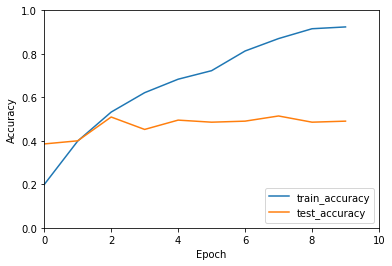

In [75]:
plt.plot(history.history['accuracy'],label='train_accuracy')
plt.plot(history.history['val_accuracy'],label = 'test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.xlim([0, 10])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,
                                     test_labels,
                                     verbose=2)

In [76]:
print('Test Accuracy is',test_acc)

Test Accuracy is 0.49047619104385376


In [2]:
import sys
sys.version

'3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]'